In [1]:
%matplotlib widget

import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed

Using MPI version 4.0, 1 processes


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# set up simulation constants

resolution = 20

n_fusedSilica = 1.44
n_PDMS = 1.4
n_amorphousSi = 3.48

a = 0.680   # lattice period 

#pml_thickness = round(wavelength / 2,3)
pml_thickness = 0.780
height_pillar = 1.020
width_PDMS = 1.560
width_fusedSilica = 0.780

cell_x = a
cell_y = a
cell_z = round(2*pml_thickness + width_PDMS + height_pillar +  width_fusedSilica, 3)

center_PDMS = round(0.5*(height_pillar + width_PDMS + pml_thickness) 
                  + (pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_fusedSilica = round(0.5*(pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_pillar = round(pml_thickness + width_fusedSilica + 0.5*height_pillar
                    - 0.5*cell_z, 3) 

z_fusedSilica = pml_thickness + width_fusedSilica
z_PDMS = height_pillar + width_PDMS + pml_thickness


In [3]:
cell_z

4.92

In [4]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_fusedSilica), 
                    center=mp.Vector3(0,0,center_fusedSilica),
                    material=mp.Medium(index=n_fusedSilica)),
            mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_PDMS),
                    center=mp.Vector3(0,0,center_PDMS),
                    material=mp.Medium(index=n_PDMS))]

k_point = mp.Vector3(0,0,0)

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num = 15 # this is the number of pillars we will build
data = np.zeros((3,num))

## set up and build source ##
############################

center_source = round(pml_thickness + width_fusedSilica*0.2 - 0.5*cell_z, 3) 
source_cmpt = mp.Ey

sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]


In [5]:
## Set up simulation ##
######################

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]

sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)

nfreq = 1
df = 0
fr_center = round(0.5*cell_z - pml_thickness - 0.3*width_PDMS, 3)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))

flux_object = sim.add_flux(freq, df, nfreq, fr)

sim.run(until=200)  # initial conditions

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0022738 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
time for set_epsilon = 0.0517941 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)


108.17519898817523
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)


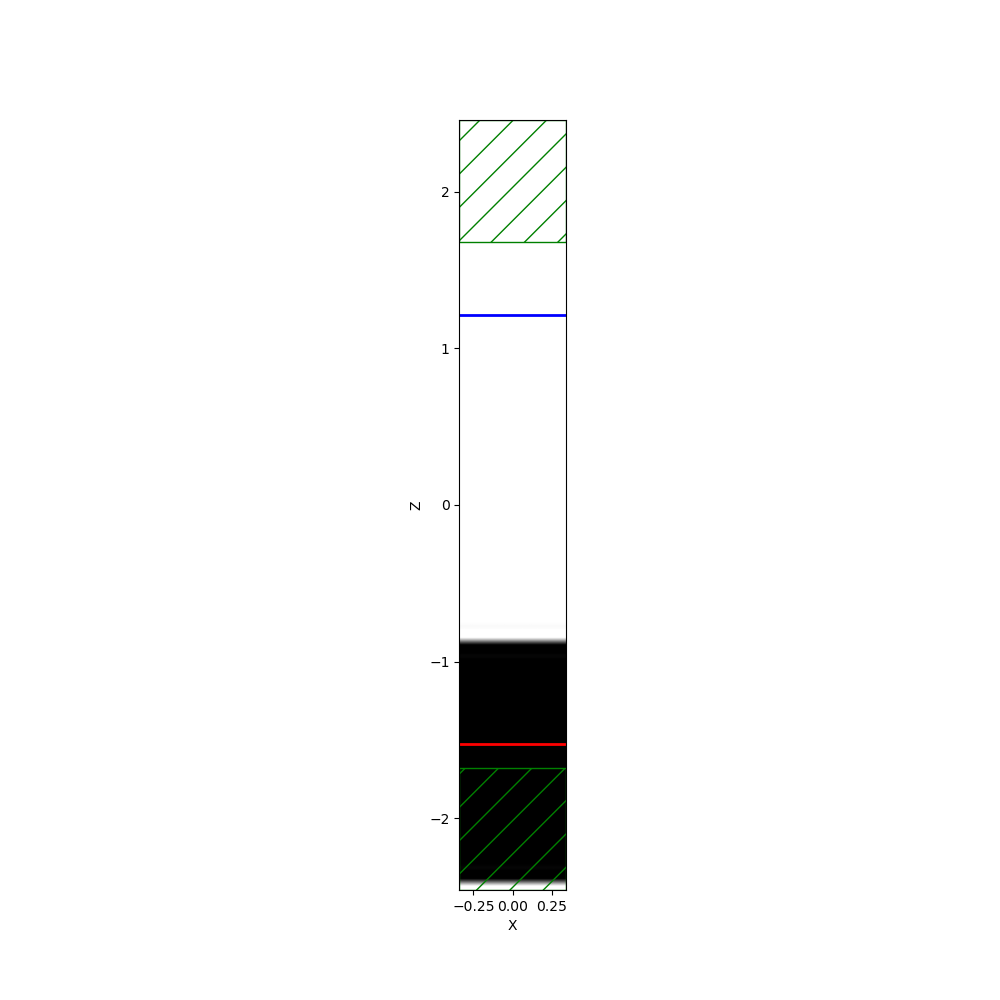

In [6]:
initial_flux = mp.get_fluxes(flux_object)[0]   
print(initial_flux)

# plot an x-z cross section
plt.close("all")
plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)
#plt.savefig("before_pillar.png")

In [7]:
print(center_source)
print(center_fusedSilica)

-1.524
-1.68


In [ ]:
sim.reset_meep()

pbar = tqdm(total=num,leave=False)
for i,radius in enumerate(np.linspace(0.075,0.25,num=num)):
    geometry.append(mp.Cylinder(radius=radius,
                        height=height_pillar,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_pillar),
                        material=mp.Medium(index=n_amorphousSi)))

    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)
    
    flux_object = sim.add_flux(freq, df, nfreq, fr)  

    sim.run(until=200)
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase
    if(radius!=0.25):
        sim.reset_meep()
        print(f"i= {i},radius={radius}")
        geometry.pop(-1)
    pbar.update(1)
pbar.close()


  0%|                                                                         | 0/15 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00187111 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.075, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0607939 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

In [ ]:
# plot an x-z cross section
plt.close("all")
plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)

In [ ]:
### plot transmission and phase as a function of pillar radius ###
plt.close("all")

radii = data[0,:]
flux_list = data[1,0:] / initial_flux
phase_list = data[2,0:]

plt.style.use('seaborn-colorblind')

tickfontsize=22
labelfontsize=26
titlefontsize=30

fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])
ax.set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
ax.set_ylim([0,1])
ax.set_ylabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
ax.plot(radii,flux_list,'b',label='Transmission')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)

twin1 = ax.twinx()
twin1.set_ylim([-np.pi,np.pi])
twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
twin1.plot(radii,phase_list,'r',label='Phase')
twin1.tick_params(axis='y', labelcolor = 'red')

plt.grid(False)
plt.tight_layout()